## Housing Prices Competition for Kaggle Learn Users

In [277]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV



In [278]:
train = pd.read_csv("./data/home-data-for-ml-course/train.csv")
test = pd.read_csv("./data/home-data-for-ml-course/test.csv")

#### Functions

In [279]:
def transform_dataset(data):
    #drop columns with nulls
    data.drop(columns=["MiscFeature","MasVnrType","Alley"], inplace=True)
    for col in ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2","GarageType","GarageFinish","GarageQual","GarageCond","PoolQC","Fence","FireplaceQu"]:
        data[col] = data[col].fillna('NA')

    #For all other categorical columns is Na -> most_frequent
    col_categories = data.select_dtypes(include='object').columns
    for col in col_categories:
        most_frequent = data[col].mode()[0]
        data[col] = data[col].fillna(most_frequent)
    return data

In [280]:
train.select_dtypes(include='object').columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

#### Overview

In [281]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [282]:
train.shape

(1460, 81)

In [283]:
train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [284]:
train.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [285]:
train = transform_dataset(train)
test = transform_dataset(test)



numeric_columns = train.select_dtypes(exclude=["object"])
category_columns = train.select_dtypes(include=["object"])

In [286]:
test.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      227
LotArea            0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
Length: 77, dtype: int64

In [287]:
test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,...,0,120,0,NA,MnPrv,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,NA,NA,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,NA,MnPrv,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,NA,NA,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,IR1,HLS,AllPub,Inside,...,0,144,0,NA,NA,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,NA,NA,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,NA,NA,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,NA,NA,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,NA,MnPrv,700,7,2006,WD,Normal


In [288]:
numeric_columns.isnull().sum()

Id                 0
MSSubClass         0
LotFrontage      259
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         8
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       81
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
SalePrice          0
dtype: int64

In [289]:
category_columns.isnull().sum()

MSZoning         0
Street           0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinType2     0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
KitchenQual      0
Functional       0
FireplaceQu      0
GarageType       0
GarageFinish     0
GarageQual       0
GarageCond       0
PavedDrive       0
PoolQC           0
Fence            0
SaleType         0
SaleCondition    0
dtype: int64

In [290]:
category_columns

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,NA,Attchd,RFn,TA,TA,Y,NA,NA,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,TA,Attchd,RFn,TA,TA,Y,NA,NA,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,TA,Attchd,RFn,TA,TA,Y,NA,NA,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,Gd,Detchd,Unf,TA,TA,Y,NA,NA,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,TA,Attchd,RFn,TA,TA,Y,NA,NA,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,TA,Attchd,RFn,TA,TA,Y,NA,NA,WD,Normal
1456,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,...,TA,Attchd,Unf,TA,TA,Y,NA,MnPrv,WD,Normal
1457,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,...,Gd,Attchd,RFn,TA,TA,Y,NA,GdPrv,WD,Normal
1458,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,NA,Attchd,Unf,TA,TA,Y,NA,NA,WD,Normal


In [291]:
train.shape

(1460, 78)

#### Duplicates

In [292]:
#Remove duplicates if exists
train.drop(columns=["Id"],inplace=True)
train.drop_duplicates(keep="first")


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,NA,NA,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,NA,NA,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,NA,NA,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,NA,NA,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,NA,NA,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,NA,NA,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,NA,MnPrv,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,NA,GdPrv,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,NA,NA,0,4,2010,WD,Normal,142125


In [293]:
train.shape

(1460, 77)

#### Outliers

In [294]:
train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


#### Correlation

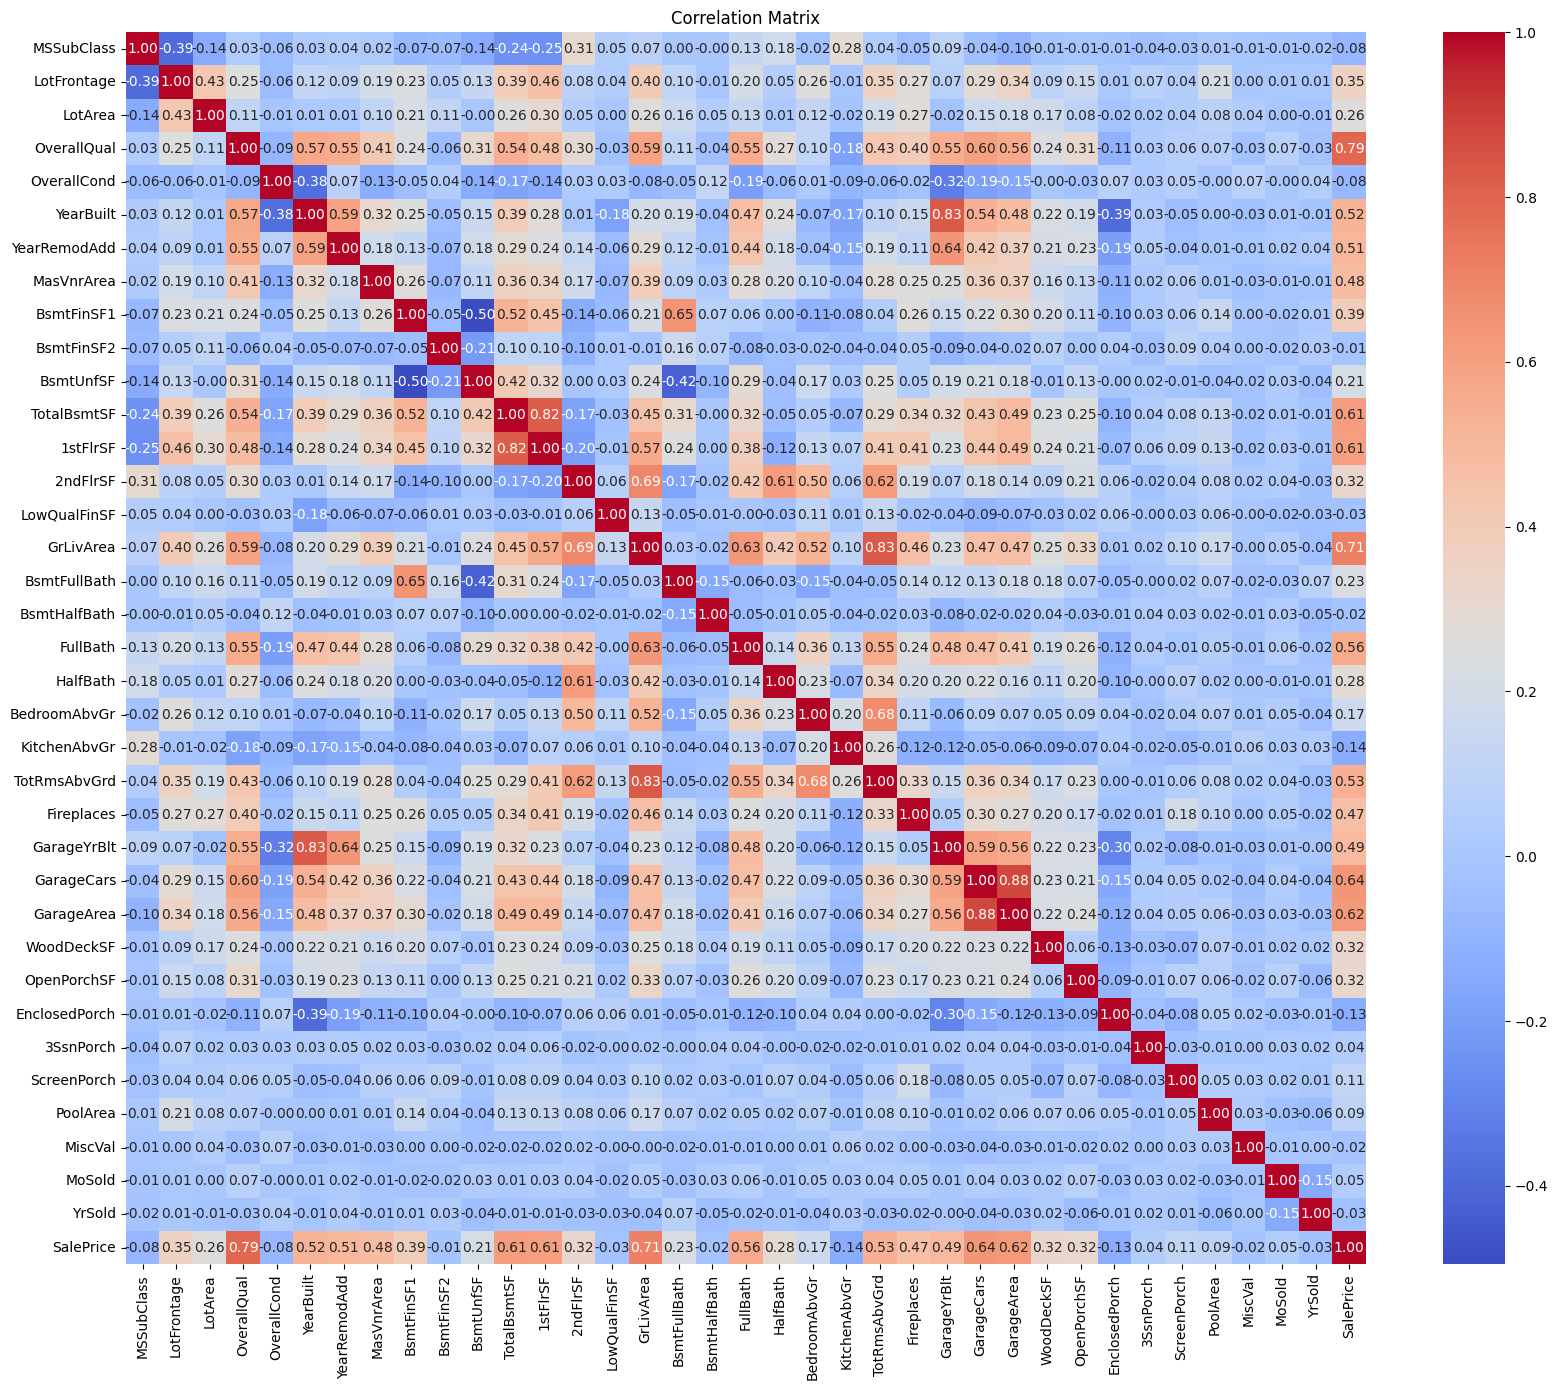

In [295]:
corr_matrix = train.corr(numeric_only=True)

# Heatmap
plt.figure(figsize=(20,16))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [296]:
corr_matrix = train.corr(numeric_only=True).abs()

# Find features highly correlated with each other (but not with the target)
high_corr_pairs = [
    (col1, col2, corr_matrix.loc[col1, col2])
    for col1 in corr_matrix.columns
    for col2 in corr_matrix.columns
    if col1 != col2 and corr_matrix.loc[col1, col2] > 0.82
]
high_corr_pairs

[('YearBuilt', 'GarageYrBlt', 0.8256674841743408),
 ('GrLivArea', 'TotRmsAbvGrd', 0.8254893743088425),
 ('TotRmsAbvGrd', 'GrLivArea', 0.8254893743088425),
 ('GarageYrBlt', 'YearBuilt', 0.8256674841743408),
 ('GarageCars', 'GarageArea', 0.882475414281462),
 ('GarageArea', 'GarageCars', 0.882475414281462)]

In [297]:
# Removing Correlated columns
train = train.drop(columns=['GarageArea','GarageYrBlt','EnclosedPorch'], axis = 1)
test = test.drop(columns=['GarageArea','GarageYrBlt','EnclosedPorch'], axis = 1)

#### Transformers

In [298]:
columns_one_hot = ["MSSubClass","MSZoning","LandContour","LotConfig","Neighborhood","Condition1","Condition2","BldgType","HouseStyle","RoofStyle","RoofMatl","Exterior1st","Exterior2nd", \
                   "Foundation","Heating","Electrical","GarageType","SaleType","SaleCondition","Functional"]
category_orders = [
    ['IR3', 'IR2', 'IR1', 'Reg'],                        # LotShape
    ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],               # Utilities
    ['Sev', 'Mod', 'Gtl'],                               # LandSlope
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],                      # ExterQual
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],                      # ExterCond
    ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],                # BsmtQual
    ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],                # BsmtCond
    ['NA', 'No', 'Mn', 'Av', 'Gd'],                      # BsmtExposure
    ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],    # BsmtFinType1
    ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],    # BsmtFinType2
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],                      # HeatingQC
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],                      # KitchenQual
    ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],                # FireplaceQu
    ['NA', 'Unf', 'RFn', 'Fin'],                         # GarageFinish
    ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],                # GarageQual
    ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],                # GarageCond
    ['N', 'P', 'Y'],                                     # PavedDrive
    ['Grvl','Pave'],                                     # Street
    ['N','Y'],                                           # CentralAir
    ['NA', 'Fa', 'TA', 'Gd', 'Ex'],                      # PoolQC
    ['NA','MnWw','GdWo','MnPrv','GdPrv']                 # Fence
]

columns_ordinal = ['LotShape','Utilities','LandSlope','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC', \
                   'KitchenQual','FireplaceQu','GarageFinish','GarageQual','GarageCond','PavedDrive','Street','CentralAir','PoolQC','Fence']

In [299]:
# Getting Numeric columns for StandardScaler
numeric_columns = train.select_dtypes(exclude="object")
numeric_columns.columns
# We must to remove the target and other where StandarScaler has not sense


Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageCars', 'WoodDeckSF', 'OpenPorchSF', '3SsnPorch', 'ScreenPorch',
       'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [300]:
numeric_columns.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageCars,WoodDeckSF,OpenPorchSF,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,1.767123,94.244521,46.660274,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,0.747315,125.338794,66.256028,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,2.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,2.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,4.000000,857.000000,547.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [301]:
numeric_columns.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageCars', 'WoodDeckSF', 'OpenPorchSF', '3SsnPorch', 'ScreenPorch',
       'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

#### Preprocessor or Pipeline

In [302]:
columns_to_mean = ["LotFrontage", "MasVnrArea","LotArea"]#,"BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF","1stFlrSF","2ndFlrSF","2ndFlrSF","GrLivArea"]
columns_to_zero = ["BsmtFullBath","BsmtHalfBath","FullBath","HalfBath","BedroomAbvGr","KitchenAbvGr","TotRmsAbvGrd","Fireplaces","GarageCars","WoodDeckSF","OpenPorchSF", \
                   "3SsnPorch","ScreenPorch","PoolArea","MiscVal"]
columns_to_most_frequent = ["MSSubClass", "OverallQual","OverallCond","YearBuilt","YearRemodAdd","YrSold"]

preprocessor = ColumnTransformer([
    ("imputter_lotFrontage", SimpleImputer(strategy="mean"), columns_to_mean),
    ("imputter_to_zero", SimpleImputer(strategy="constant", fill_value=0), columns_to_zero),
    ("imputter_to_most_frequent", SimpleImputer(strategy="most_frequent"), columns_to_most_frequent),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first"), columns_one_hot),
    ("ordinal_enc", OrdinalEncoder(categories=category_orders,handle_unknown = 'error'), columns_ordinal)
], remainder="passthrough").set_output(transform="pandas")


#### Models

In [303]:
X = train.drop(columns=["SalePrice"], axis=1)
y = train.SalePrice

X_train, X_valid, y_train, y_valid = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 42, 
                                        shuffle      = True
                                    )

X_train_prep = preprocessor.fit_transform(X_train)
X_valid_prep = preprocessor.transform(X_valid)


/Users/jayarza/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [10, 15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


##### RidgeCV

In [304]:
model = RidgeCV()#LinearRegression()

model.fit(X_train_prep, y_train)


RidgeCV()

In [305]:

y_pred = model.predict(X_valid_prep)

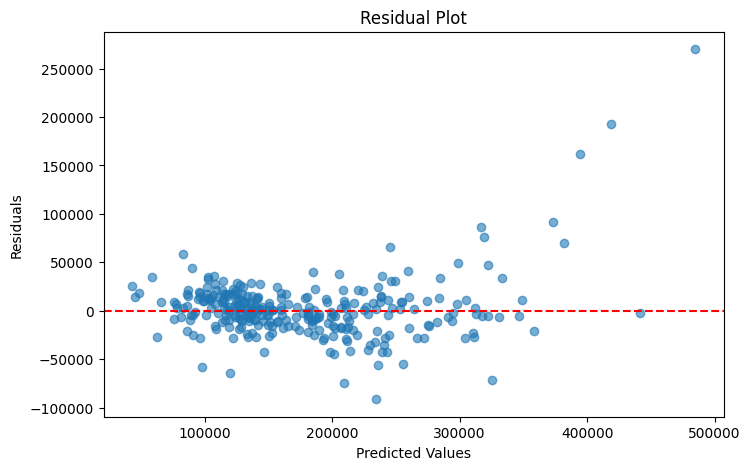

In [306]:
residuals = y_valid - y_pred

plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

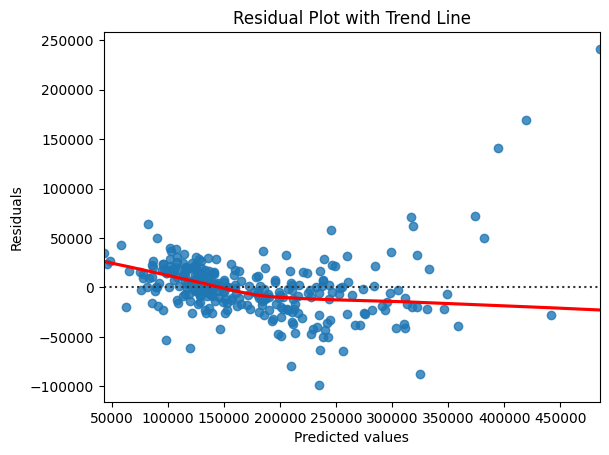

In [307]:
import seaborn as sns
sns.residplot(x=y_pred, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual Plot with Trend Line")
plt.show()

In [308]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_valid, y_pred, squared=False)
print("RMSE:", rmse)

RMSE: 31749.295367808765


/Users/jayarza/.local/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


##### XGBoost

In [309]:
import xgboost as xgb

In [310]:
model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

model.fit(X_train_prep, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [311]:
y_pred = model.predict(X_valid_prep)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

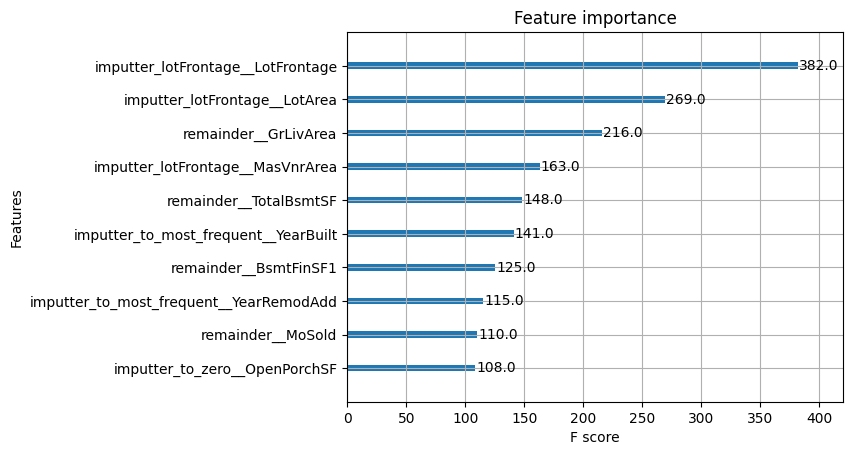

In [312]:
xgb.plot_importance(model, max_num_features=10)

In [313]:
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print("RMSE:", rmse)

RMSE: 25027.00149175577


In [314]:
X_test_prep = preprocessor.transform(test.drop(columns=["Id"]))


/Users/jayarza/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [315]:

test_predictions = model.predict(X_test_prep)

In [316]:
finish = pd.DataFrame({'Id': test.Id, 'SalePrice': test_predictions})
# save to csv
finish.to_csv('submission.csv', index=False)